In [1]:
from pandas import read_csv, DataFrame, Series, to_numeric, to_datetime
from matplotlib.pyplot import savefig, subplots, show
from dslabs_functions import plot_bar_chart

In [6]:
#filenames = ["lab2/data/traffic_accidents.csv", "lab2/data/Combined_Flights_2022.csv"]
filenames = ["lab2/dimensionality_correlation/data/traffic_accidents.csv"]
file_tag = "lab2/"

In [3]:
def load_datasets(filenames: list[str]) -> list[DataFrame]:
    dfs: list[DataFrame] = []
    for i, filename in enumerate(filenames):
        print(f'Loading dataset from {filename}...')
        dfs.append(read_csv(filename, na_values=""))
        print(dfs[i].shape)
        filenames[i] = filename
    return dfs

def apply_scale_and_annotate(ax, values):
    from matplotlib.ticker import FuncFormatter
    if not values:
        return
    maxv = max(values)
    if maxv >= 1_000_000:
        factor = 1_000_000
        unit = "M"
    elif maxv >= 1_000:
        factor = 1_000
        unit = "K"
    else:
        factor = 1
        unit = ""

    def yfmt(x, pos):
        if factor == 1:
            return f"{int(x)}"
        val = x / factor
        if val.is_integer():
            return f"{int(val)}{unit}"
        return f"{val:.1f}{unit}"

    ax.yaxis.set_major_formatter(FuncFormatter(yfmt))
    # Clear any existing labels first
    for text in ax.texts:
        text.remove()
    for p in ax.patches:
        h = p.get_height()
        if h == 0 or h is None:
            continue
        if factor == 1:
            label = f"{int(h)}"
        else:
            val = h / factor
            # use one decimal for small values, integer for larger to reduce clutter
            label = f"{val:.1f}{unit}" if val < 10 else f"{int(val)}{unit}"
        ax.annotate(
            label,
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=45,
            xytext=(0, 3),
            textcoords="offset points",
        )

def get_nr_variables(df: DataFrame) -> dict[str, int]:
    return {"nr records": df.shape[0], "nr variables": df.shape[1]}

def plot_nr_variables(dfs: list[DataFrame], file_tag: str, save=False) -> None:
    print("Plotting nr of records vs nr of variables...")
    fig, axs = subplots(1, len(dfs), sharey=True, figsize=(6, 4))
    for i in range(len(dfs)):
        values: dict[str, int] = get_nr_variables(dfs[i])
        plot_bar_chart(
            list(values.keys()), 
            list(values.values()), 
            ax=axs[i] if len(dfs) > 1 else None, 
            #title="Nr of records vs nr variables"
        )
    fig.tight_layout()
    show()
    if save:
        savefig(f"images/{file_tag}records_variables.png")
        savefig(f"images/{file_tag}records_variables.eps", format="eps")

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)
    return variable_types

def plot_variable_types(dfs: list[DataFrame], file_tag: str, save=False) -> None:
    print("Plotting variable types...")
    fig, axs = subplots(1, len(dfs), sharey=True, figsize=(6, 2))
    for i in range(len(dfs)):
        variable_types: dict[str, list] = get_variable_types(dfs[i])
        print(f'Domain {i+1} variable_types: {variable_types}')
        counts: dict[str, int] = {}
        for tp in variable_types.keys():
            counts[tp] = len(variable_types[tp])
        plot_bar_chart(
            list(counts.keys()), 
            list(counts.values()), 
            ax=axs[i] if len(dfs) > 1 else None, 
            #title=f"Nr of variables per type for Domain {i+1}"
        )
    fig.tight_layout()
    show()
    if save:
        savefig(f"images/{file_tag}variable_types.png")
        savefig(f"images/{file_tag}variable_types.eps", format="eps")

def get_nr_missing_values(df: DataFrame) -> dict[str, int]:
    mv: dict[str, int] = {}
    for var in df.columns:
        nr: int = df[var].isna().sum()
        if nr > 0:
            mv[var] = nr
    return mv

def plot_nr_missing_values(dfs: list[DataFrame], file_tag: str, save=False) -> None:
    print("Plotting nr of missing values per variable...")
    fig, axs = subplots(1, len(dfs), sharey=True, figsize=(10, 4))
    
    for i in range(len(dfs)):
        mv: dict[str, int] = get_nr_missing_values(dfs[i])
        plot_bar_chart(
            list(mv.keys()),
            list(mv.values()),
            ax=axs[i] if len(dfs) > 1 else None,
            #title=f"Nr of missing values per variable for Domain {i+1}",
            ylabel="nr missing values",
        )
        apply_scale_and_annotate(axs[i], list(mv.values()))
    fig.tight_layout()
    show()
    if save:
        savefig(f"images/{file_tag}nr_missing_values.png")
        savefig(f"images/{file_tag}nr_missing_values.eps", format="eps")

def remove_ID_columns(dfs: list[DataFrame]) -> list[DataFrame]:
    print("Removing ID columns from Domain 2 dataset...")
    for i in range(len(dfs)):
        cols_to_remove: list[str] = [col for col in dfs[i].columns if 'ID' in col]
        if cols_to_remove:
            dfs[i] = dfs[i].drop(columns=cols_to_remove, errors='ignore')
            print(f'New shape of Domain {i+1} dataset: {dfs[i].shape}')
    return dfs

def remove_constant_columns(dfs: list[DataFrame]) -> list[DataFrame]:
    print("Removing constant columns from datasets...")
    for i in range(len(dfs)):
        nunique = dfs[i].nunique()
        constant_columns = nunique[nunique == 1].index.tolist()
        if constant_columns:
            print(f"Removing constant columns from Domain {i+1} dataset: {constant_columns}")
            dfs[i] = dfs[i].drop(columns=constant_columns)
            print(f'New shape of Domain {i+1} dataset: {dfs[i].shape}')
    return dfs


def get_correlation_matrix(df: DataFrame) -> DataFrame:
    variable_types: dict[str, list] = get_variable_types(df)
    numeric: list[str] = variable_types["numeric"]
    corr_mtx: DataFrame = df[numeric].corr().abs()
    return corr_mtx, numeric

def plot_correlation_matrices(dfs: list[DataFrame], file_tag: str, save=False) -> None:
    from seaborn import heatmap
    from matplotlib.pyplot import figure

    print("Plotting correlation matrices...")
    for i in range(len(dfs)):
        corr_mtx, numeric = get_correlation_matrix(dfs[i])
        fig = figure(figsize=(10, 8))
        ax = heatmap(
            corr_mtx,
            xticklabels=numeric,
            yticklabels=numeric,
            annot=True if i == 0 else False,
            cmap="Blues",
            vmin=0,
            vmax=1,
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
        fig.tight_layout()
        show()
        if save:
            savefig(f"{file_tag}/images/correlation_analysis_domain{i+1}.png")
            savefig(f"{file_tag}/images/correlation_analysis_domain{i+1}.eps", format="eps")

In [7]:
# Load datasets
dfs = load_datasets(filenames)

Loading dataset from lab2/dimensionality_correlation/data/traffic_accidents.csv...
(209306, 24)


Plotting nr of records vs nr of variables...


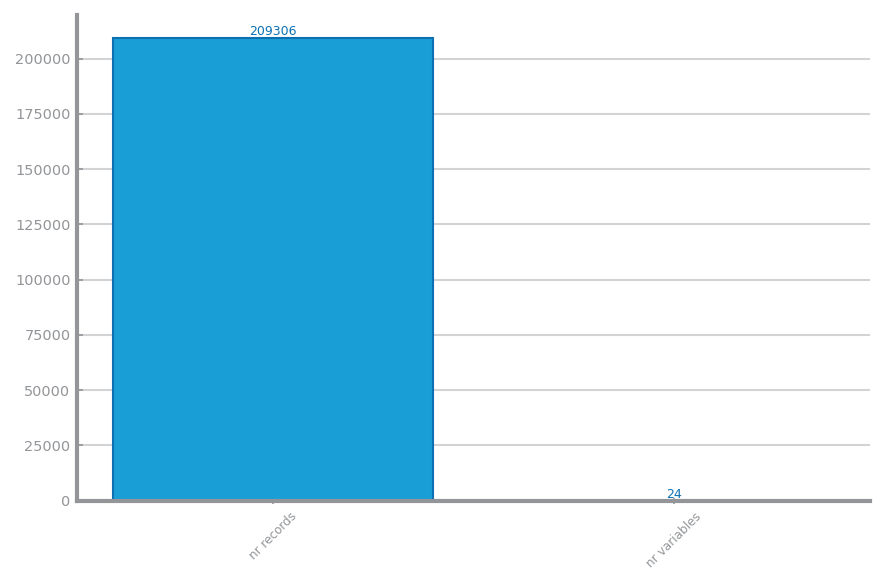

In [8]:
# Plot Number of Variables vs Number of Records
plot_nr_variables(dfs, file_tag, save=False)

Plotting variable types...
Domain 1 variable_types: {'numeric': ['num_units', 'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication', 'crash_hour', 'crash_day_of_week', 'crash_month'], 'binary': ['crash_type', 'intersection_related_i'], 'date': ['crash_date'], 'symbolic': ['traffic_control_device', 'weather_condition', 'lighting_condition', 'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect', 'damage', 'prim_contributory_cause', 'most_severe_injury']}


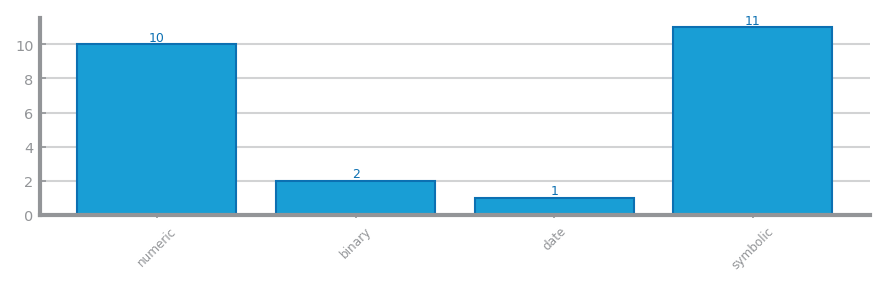

In [9]:
# Plot Variable Types
plot_variable_types(dfs, file_tag, save=False)

In [ ]:
# Plot Number of Missing Values per Variable
plot_nr_missing_values(dfs, file_tag, save=False)

Plotting correlation matrices...


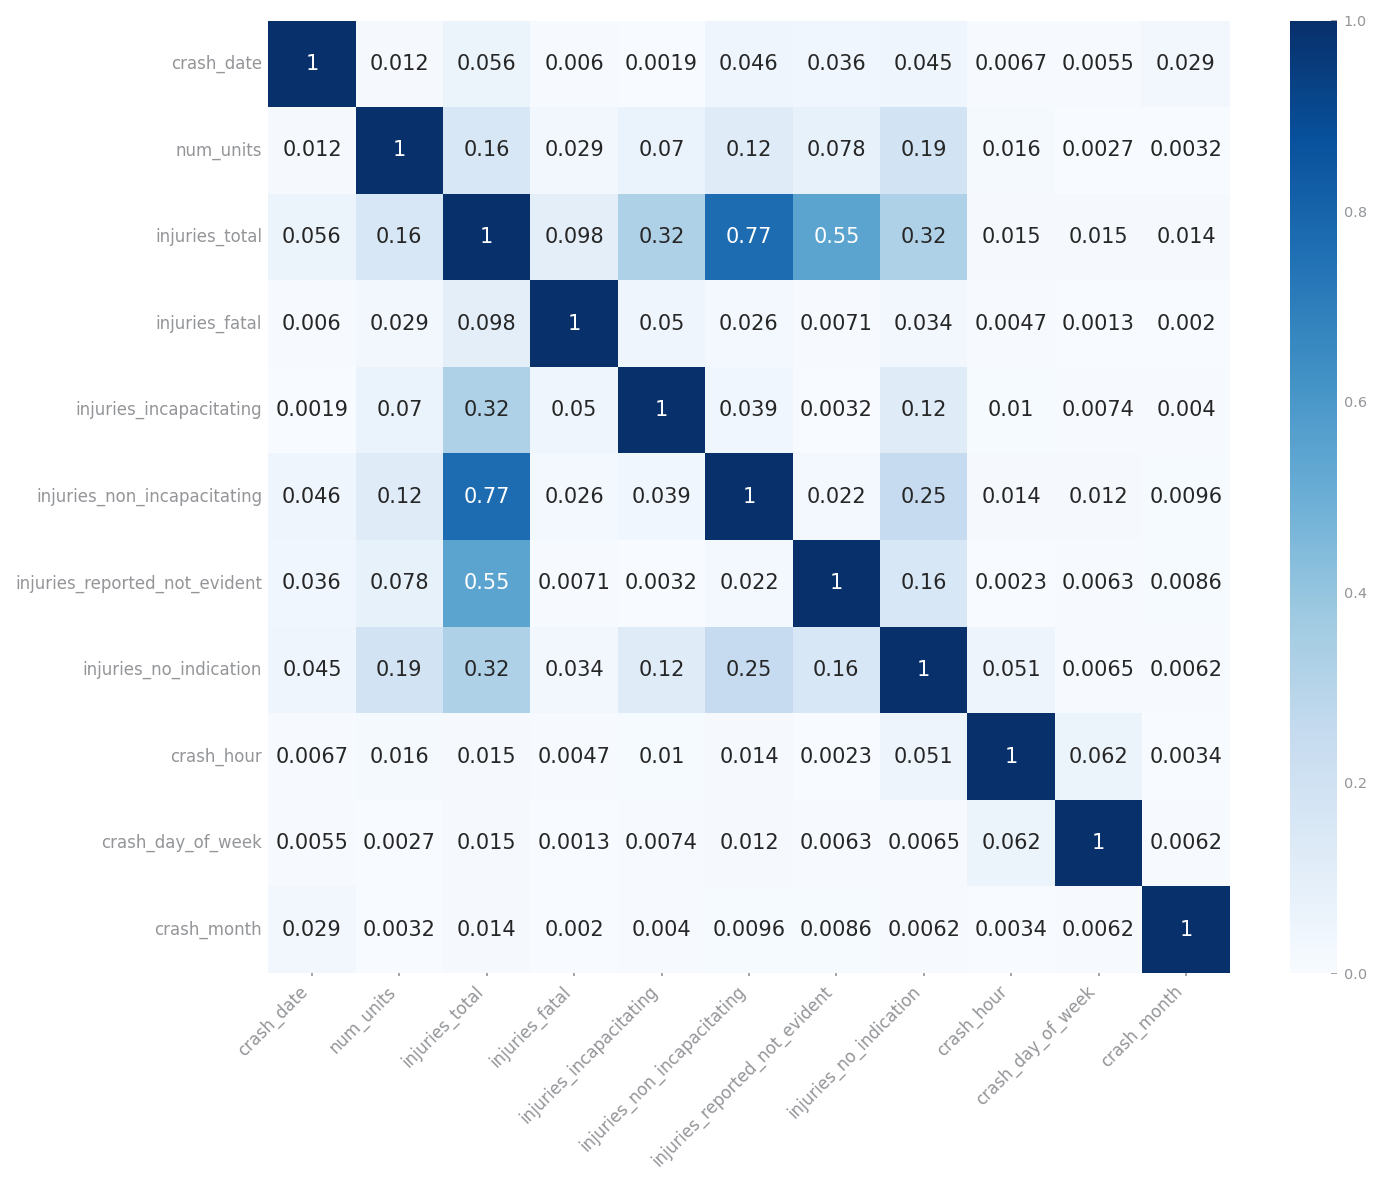

<Figure size 600x450 with 0 Axes>

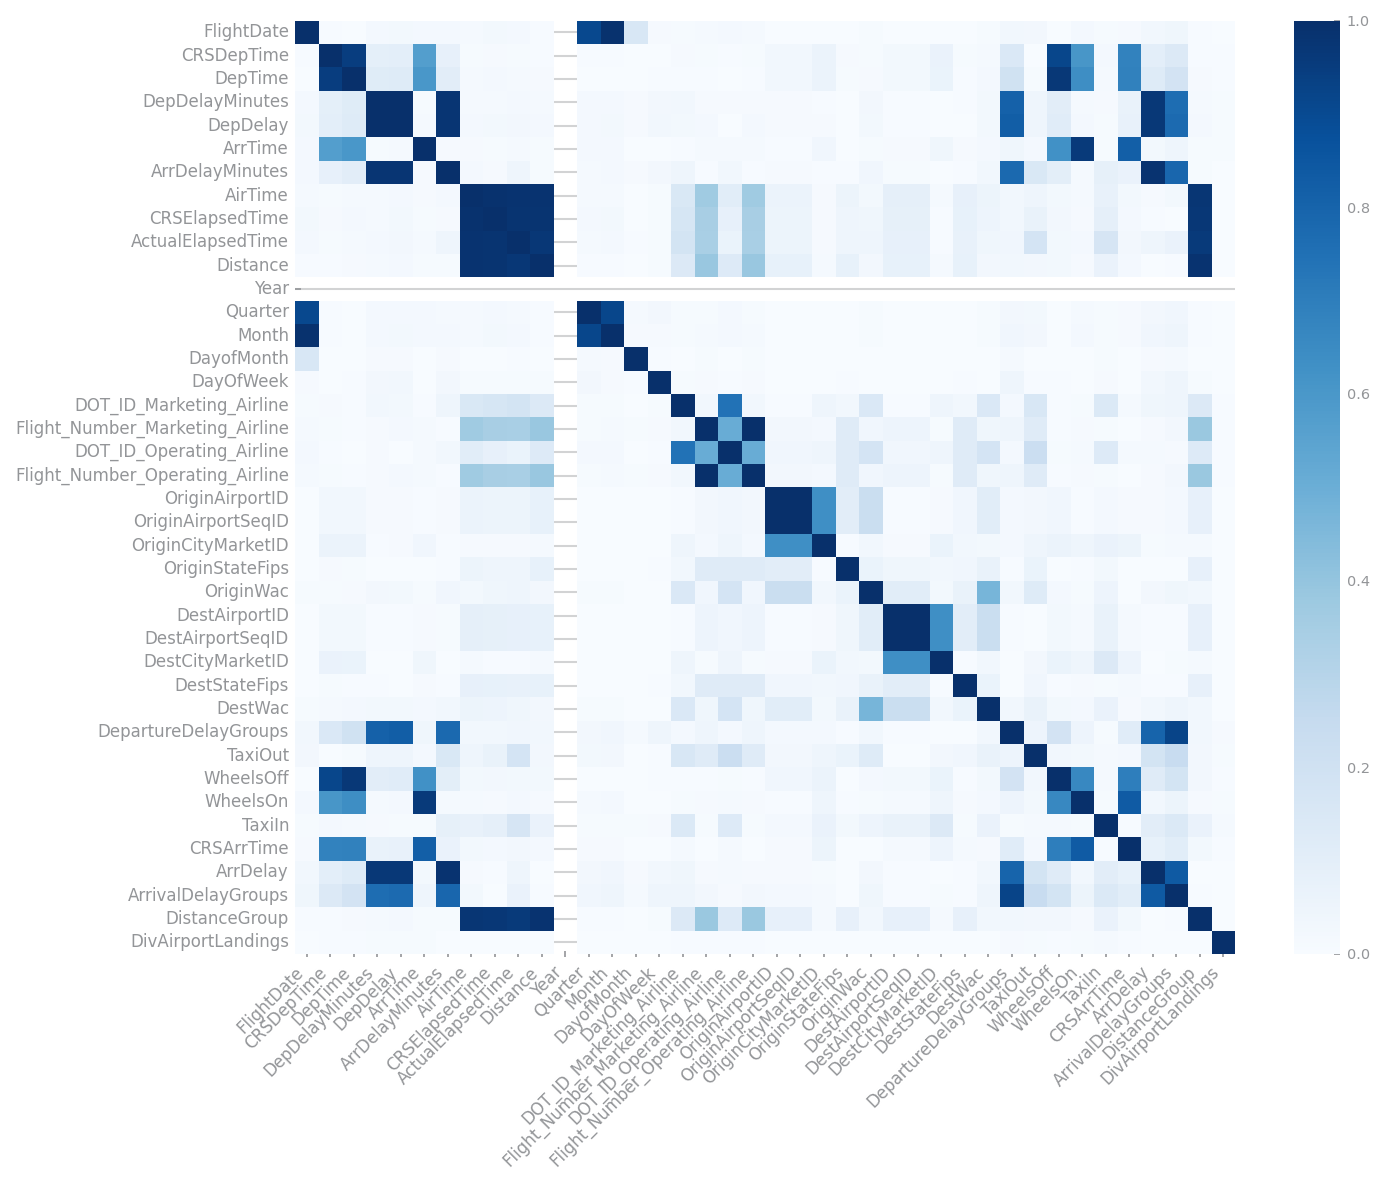

<Figure size 600x450 with 0 Axes>

In [ ]:
# Plot correlation matrices
dfs = remove_ID_columns(dfs)
dfs = remove_constant_columns(dfs)
plot_correlation_matrices(dfs, file_tag, save=False)